In [9]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from scipy.interpolate import griddata as gd
from pykrige.ok import OrdinaryKriging
from matplotlib import cm
import netCDF4 as nc
import scipy.io
import glob,csv
from IPython.display import Image
from mpl_toolkits.basemap import Basemap
%matplotlib inline

#Pa_part Interpolation

In [10]:
data=scipy.io.loadmat('Pa_part.mat')
NEMO_dep=data['NEMO_dep']
Pa_diss=data['Pa_part']
lons=data['lons']
lats=data['lats']

In [11]:
layer=20
x=lons[layer,:]
y=lats[layer,:]
z=Pa_diss[layer,:]
x_ma=np.ma.masked_where(abs(x)<= 1e-200,x)
y_ma=np.ma.masked_where(abs(y)<= 1e-200,y)
z_ma=np.ma.masked_where(abs(z)<= 1e-200,z)

In [12]:
coordinate_name=glob.glob('/ocean/xiaoxiny/research/NEMO-code/NEMOGCM/CONFIG/test/EXP00/coordinates*.nc')
coordinate_obj=nc.Dataset(coordinate_name[0])
nav_lon=coordinate_obj.variables['nav_lon'][:]
nav_lat=coordinate_obj.variables['nav_lat'][:]

In [13]:
m = Basemap(projection='npstere',boundinglat=55,lon_0=0,resolution='l')
x_dis,y_dis = m(x_ma, y_ma)
x_lon,y_lat = m(nav_lon, nav_lat)
a,b=m(0,90)

In [14]:
print x_ma.shape
print nav_lat[147,50]
print a,b

(5,)
89.5671
4017535.2761 4017535.2761


In [25]:
xx_lon=np.empty([149,182])
yy_lat=np.empty([149,182])
xx_dis=np.empty([len(x_dis)])
yy_dis=np.empty([len(x_dis)])

for j in range (182):
    for i in range (149):
        
        if nav_lon[i,j]>0:
            b_useless, b = m(nav_lon[i,j],nav_lat[i,j])
            yy_lat[i,j]=2*b-y_lat[i,j]
        else:
            yy_lat[i,j]=y_lat[i,j]

        xx_lon[i,j]=x_lon[i,j]-a
        
xx_lon_ma=np.ma.masked_where(nav_lat<55,xx_lon)
yy_lat_ma=np.ma.masked_where(nav_lat<55,yy_lat)

for k in range (len(x_dis)):
        if x_ma[k]>0:
            b_useless, bb = m(x_ma[k],y_ma[k])
            yy_dis[k]=2*bb-y_dis[k]
        else:
            yy_dis[k]=y_dis[k]
        
        xx_dis[k]=x_dis[k]-a
xx_dis=np.ma.masked_where(np.isnan(xx_dis),xx_dis)
yy_dis=np.ma.masked_where(np.isnan(yy_dis),yy_dis)

In [27]:
print xx_dis
print yy_dis
print z_ma

xxx_dis=([192614.73013352836,79705.45158205926,-38780.83980416367,121914.65654541273])
yyy_dis=([3906329.10980752,4225175.076412903,3574268.2487934018,3247796.428675311])
zzz_ma=([0.004667166866746699,0.0071194124708707,0.005216062895746534,0.008])

[192614.73013352836 -- 79705.45158205926 -38780.83980416367
 121914.65654541273]
[3906329.10980752 -- 4225175.076412903 3574268.2487934018 3247796.428675311]
[0.004667166866746699 -- 0.0071194124708707 0.005216062895746534 0.008]


In [28]:
OK = OrdinaryKriging(xxx_dis,yyy_dis, zzz_ma, variogram_model='linear', verbose=False, enable_plotting=False)
Pa_interp, ss = OK.execute('points',xx_lon, yy_lat)
Pa_interp=Pa_interp.reshape(149,182)

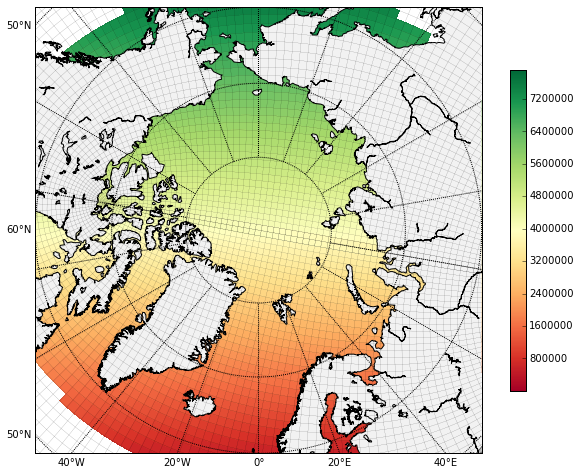

In [48]:
#nc_filename=sorted(glob.glob('Pa/*.csv'))
fig=plt.figure(figsize=(10, 10)); ax=plt.gca()
m = Basemap(projection='npstere',boundinglat=60,lon_0=0,resolution='l')
m.drawcoastlines()
m.fillcontinents(color = '0.95')
m.drawparallels(np.arange(-80.,81.,10.),labels=[1, 0, 0, 0])
m.drawmeridians(np.arange(-180.,181.,20.),labels=[0, 0, 0, 1])
x,y = m(nav_lon, nav_lat)
plt.plot(x,y,x.T,y.T,color='k',linewidth=0.1)
CS = m.pcolor(x,y,yy_lat_ma,cmap=plt.cm.RdYlGn)
CBar = plt.colorbar(CS, shrink=0.575)

plt.show()

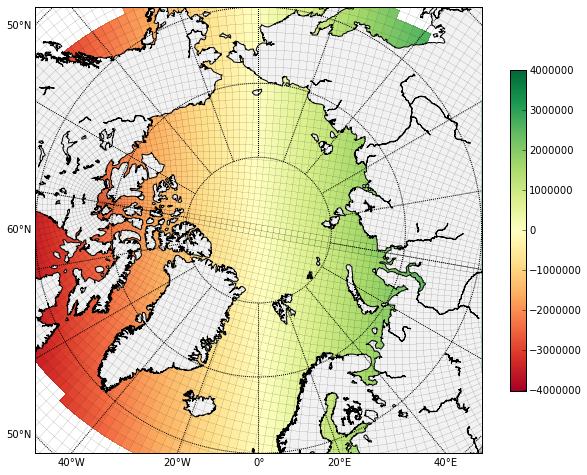

In [47]:
#nc_filename=sorted(glob.glob('Pa/*.csv'))
fig=plt.figure(figsize=(10, 10)); ax=plt.gca()
m = Basemap(projection='npstere',boundinglat=60,lon_0=0,resolution='l')
m.drawcoastlines()
m.fillcontinents(color = '0.95')
m.drawparallels(np.arange(-80.,81.,10.),labels=[1, 0, 0, 0])
m.drawmeridians(np.arange(-180.,181.,20.),labels=[0, 0, 0, 1])
x,y = m(nav_lon, nav_lat)
plt.plot(x,y,x.T,y.T,color='k',linewidth=0.1)
CS = m.pcolor(x,y,xx_lon_ma,cmap=plt.cm.RdYlGn)
CBar = plt.colorbar(CS, shrink=0.575)

plt.show()

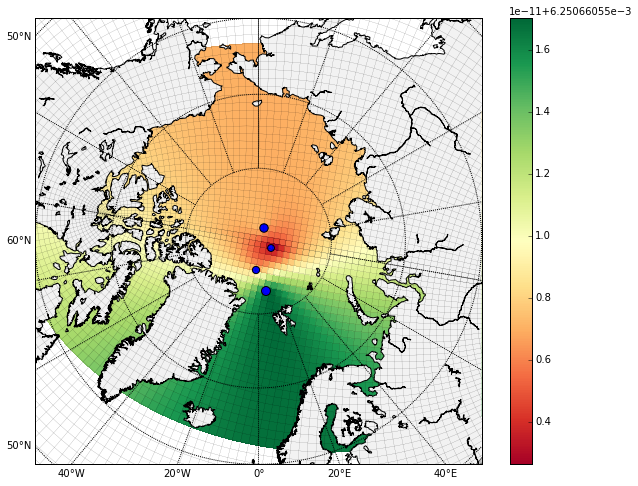

In [46]:
fig=plt.figure(figsize=(10, 10)); ax=plt.gca()
m = Basemap(projection='npstere',boundinglat=60,lon_0=0,resolution='l')
m.drawcoastlines()
m.fillcontinents(color = '0.95')
m.drawparallels(np.arange(-80.,81.,10.),labels=[1, 0, 0, 0])
m.drawmeridians(np.arange(-180.,181.,20.),labels=[0, 0, 0, 1])
x,y = m(nav_lon, nav_lat)
plt.plot(x,y,x.T,y.T,color='k',linewidth=0.1)
CS = m.pcolor(x[120:-1,:],y[120:-1,:],Pa_interp[120:-1,:],cmap=plt.cm.RdYlGn)
CBar = plt.colorbar(CS, shrink=0.8)
#m.scatter(x[0,90],y[0,90],color='yellow',s=100)
for j in range(len(x_ma)):
    x2,y2= m(x_ma[j], y_ma[j])
    m.scatter(x2,y2,s=z[j]*10000)
plt.show()

In [37]:
print np.max(Pa_interp)
print np.min(Pa_interp)

0.00625066056704
0.00625066055264


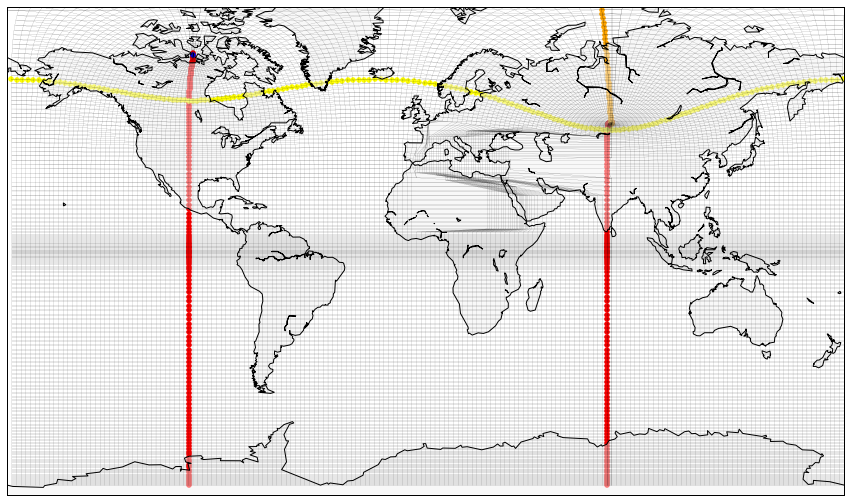

In [63]:
fig=plt.figure(figsize=(15, 10)); 
#m = Basemap(projection='npstere',boundinglat=0,lon_0=0,resolution='l')
m=Basemap(llcrnrlon=-180,llcrnrlat=-80,urcrnrlon=180,urcrnrlat=80,projection='mill')
m.drawcoastlines()
m.fillcontinents(color = '0.95',alpha=0.5)
x_lon,y_lat = m(nav_lon, nav_lat)
plt.plot(x_lon,y_lat,x_lon.T,y_lat.T,color='black',linewidth=0.09)
m.scatter(x_lon[:,0],y_lat[:,0],color='r')
m.scatter(x_lon[:,90],y_lat[:,90],color='r')
#m.scatter(x_lon[0,:],y_lat[0,:],color='orange')
m.scatter(x_lon[-1,0:45],y_lat[-1,0:45],color='orange')
m.scatter(x_lon[120,:],y_lat[120,:],color='yellow')
m.scatter(x_lon[-1,90],y_lat[-1,90],color='blue')

plt.show()

#Draft below

In [5]:
#listx = np.linspace(-180, 180, 100)
#listy = np.linspace(60, 90, 100)
listx = np.linspace(x_ma.min()-45, x_ma.max()+45, 100)
listy = np.linspace(y_ma.min()-10, 90, 100)
gridx, gridy = np.meshgrid(listx, listy)
OK = OrdinaryKriging(x_ma, y_ma, z_ma, variogram_model='linear', verbose=False, enable_plotting=False)
Pa_interp, ss = OK.execute('grid', listx, listy)
#print Pa_interp

In [6]:
nc_filename=sorted(glob.glob('Pa/*.csv'))
#print("found *.csv file: \n{}".format(nc_filename))

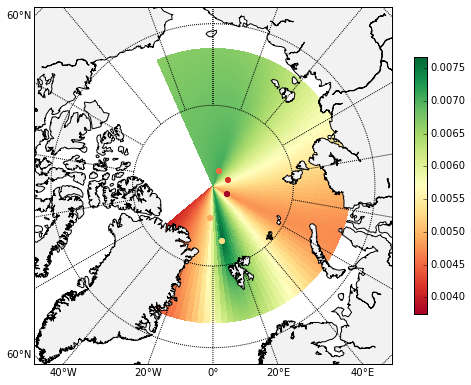

In [7]:
fig=plt.figure(figsize=(8, 8)); ax=plt.gca()
m = Basemap(projection='npstere',boundinglat=68,lon_0=0,resolution='l')
m.drawcoastlines()
m.fillcontinents(color = '0.95')
m.drawparallels(np.arange(-80.,81.,10.),labels=[1, 0, 0, 0])
m.drawmeridians(np.arange(-180.,181.,20.),labels=[0, 0, 0, 1])
x,y = m(gridx, gridy)
CS = m.pcolor(x,y,Pa_interp,cmap=plt.cm.RdYlGn)
CBar = plt.colorbar(CS, shrink=0.575)
for j in range(5):
    data=pd.read_csv(nc_filename[j])
    lon = data['long.'];
    lat = data['lat.'];
    x,y = m(lon.values,lat.values)
    m.scatter(x,y,color=cm.RdYlGn(j*25))

plt.show()

In [8]:
#help(OrdinaryKriging)

#Th part

In [9]:
data=scipy.io.loadmat('Th_part_Atc+Alt.mat')
NEMO_dep=data['NEMO_dep']
Th_diss=data['Th_part']
lons=data['lons']
lats=data['lats']

In [10]:
layer=20
x=lons[layer,:]
y=lats[layer,:]
z=Th_diss[layer,:]
x_ma=np.ma.masked_where(abs(x)<= 1e-200,x)
y_ma=np.ma.masked_where(abs(y)<= 1e-200,y)
z_ma=np.ma.masked_where(z<= 1e-200,z)
print y
print y_ma.max()

[  8.60000000e+001   8.40000000e+001   8.20000000e+001   8.10000000e+001
   7.40000000e+001   8.80000000e+001   1.03284034e+003   8.80000000e+001
   8.40000000e+001   8.30000000e+001   5.40000000e+001   5.50000000e+001
   2.41907520e-312   5.80000000e+001]
1032.84033613


In [11]:
listx = np.linspace(x_ma.min(), x_ma.max(), 300)
listy = np.linspace(50, 90, 300)
gridx, gridy = np.meshgrid(listx, listy)
OK = OrdinaryKriging(x_ma, y_ma, z_ma, variogram_model='linear', verbose=False, enable_plotting=False)
Pa_interp, ss = OK.execute('grid', listx, listy)

In [12]:
nc_filename=sorted(glob.glob('Th/*.csv'))
#print("found *.csv file: \n{}".format(nc_filename))

/home/xiaoxiny/anaconda/lib/python2.7/site-packages/numpy/ma/core.py:3855: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")


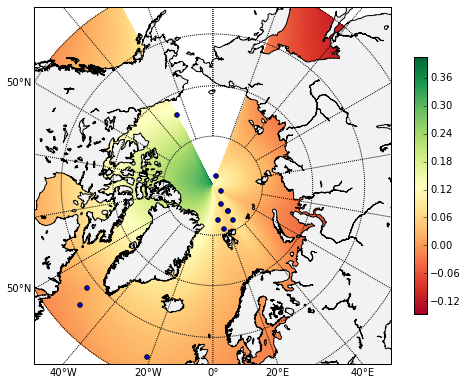

In [13]:
fig=plt.figure(figsize=(8, 8)); ax=plt.gca()
m = Basemap(projection='npstere',boundinglat=55,lon_0=0,resolution='l')
m.drawcoastlines()
m.fillcontinents(color = '0.95')
m.drawparallels(np.arange(-80.,81.,10.),labels=[1, 0, 0, 0])
m.drawmeridians(np.arange(-180.,181.,20.),labels=[0, 0, 0, 1])
x,y = m(gridx, gridy)
CS = m.pcolor(x,y,Pa_interp,cmap=plt.cm.RdYlGn)
CBar = plt.colorbar(CS, shrink=0.575)
for j in range(14):
    x2,y2 = m(x_ma[j],y_ma[j])
    m.scatter(x2,y2)#,color=cm.RdYlGn(j*25)
plt.show()

In [17]:
print Pa_interp.shape
print nav_lat.shape

(149, 182)
(149, 182)
